# Tutorial Round

In [524]:
#Import libraries
import pandas as pd
import numpy as np
import statistics as st
import math
import os

import matplotlib.pyplot as plt

In [525]:
def spread(a, b):
    return a - b

In [526]:
def OrderBookImbalance(df: pd.DataFrame):

	def ComputeImbalance(buys, sells, L):
		
		numerator, denominator, OBI = 0, 0, 0
		for i in range(L):
			bid_Q = buys[f"bid_volume_{i+1}"]
			ask_Q = sells[f"ask_volume_{i+1}"]
			numerator += bid_Q - ask_Q
			denominator += bid_Q + ask_Q
			if i+1 == L:
				OBI = numerator / denominator
			return OBI
		
	buy_cols, ask_cols = [i for i in df.columns if "bid_volume" in i], [i for i in df.columns if "ask_volume" in i]
	OBI = []
	for i in range(0,len(df)):
		buys = df[buy_cols].iloc[i]
		buys_L = buys.notna().sum()
		sells = df[ask_cols].iloc[i]
		sells_L = sells.notna().sum()
		L = np.min([buys_L, sells_L])
		OBI.append(ComputeImbalance(buys, sells, L))
	
	df["order_book_imbalance"] = OBI
	return df

Set up paths

In [527]:
THISFILE = os.getcwd()
MY_FOlDER = os.path.dirname(THISFILE)
REPO = os.path.dirname(MY_FOlDER)
DATA = os.path.join(REPO, 'data')

DATA_FILES = os.listdir(DATA)
for i in range(len(DATA_FILES)):
    filename = DATA_FILES[i]
    DATA_FILES[i] = os.path.join(DATA, filename)

DATA_FILES

['c:\\Users\\Ramon\\github\\rvargas42\\IMC_Prosperity2_BigWhales\\data\\tutorial_main_24_02_2024.csv']

In [528]:
df_1 = pd.read_csv(DATA_FILES[0], sep=';')
products = list(df_1["product"].unique())
df_1.head(5)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,AMETHYSTS,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.0
1,-2,0,STARFRUIT,5002,1,4997.0,31.0,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,5002.5,0.0
2,-2,100,AMETHYSTS,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,0.0
3,-2,100,STARFRUIT,4997,24,NaN,NaN,NaN,NaN,5003,2,5004.0,22.0,NaN,NaN,5000.0,0.0
4,-2,200,STARFRUIT,4997,2,4996.0,20.0,NaN,NaN,5003,20,NaN,NaN,NaN,NaN,5000.0,0.0


In [589]:
dfs = {}
for product in products:
    mask = df_1["product"] == product
    dfs[product] = df_1[mask].set_index("timestamp").sort_index()
    df = dfs[product]
    df["spread"] = df["ask_price_1"] - df["bid_price_1"]
    df["returns"] = df["mid_price"].pct_change()
    df['log_ret'] =  np.log(1 + df.returns)
    df["stdev"] = df["returns"].rolling(7).std()
    OrderBookImbalance(df)

dfs["AMETHYSTS"]["mid_price"].unique()
dfs["STARFRUIT"]["bid_volume_3"].mean()

24.661016949152543

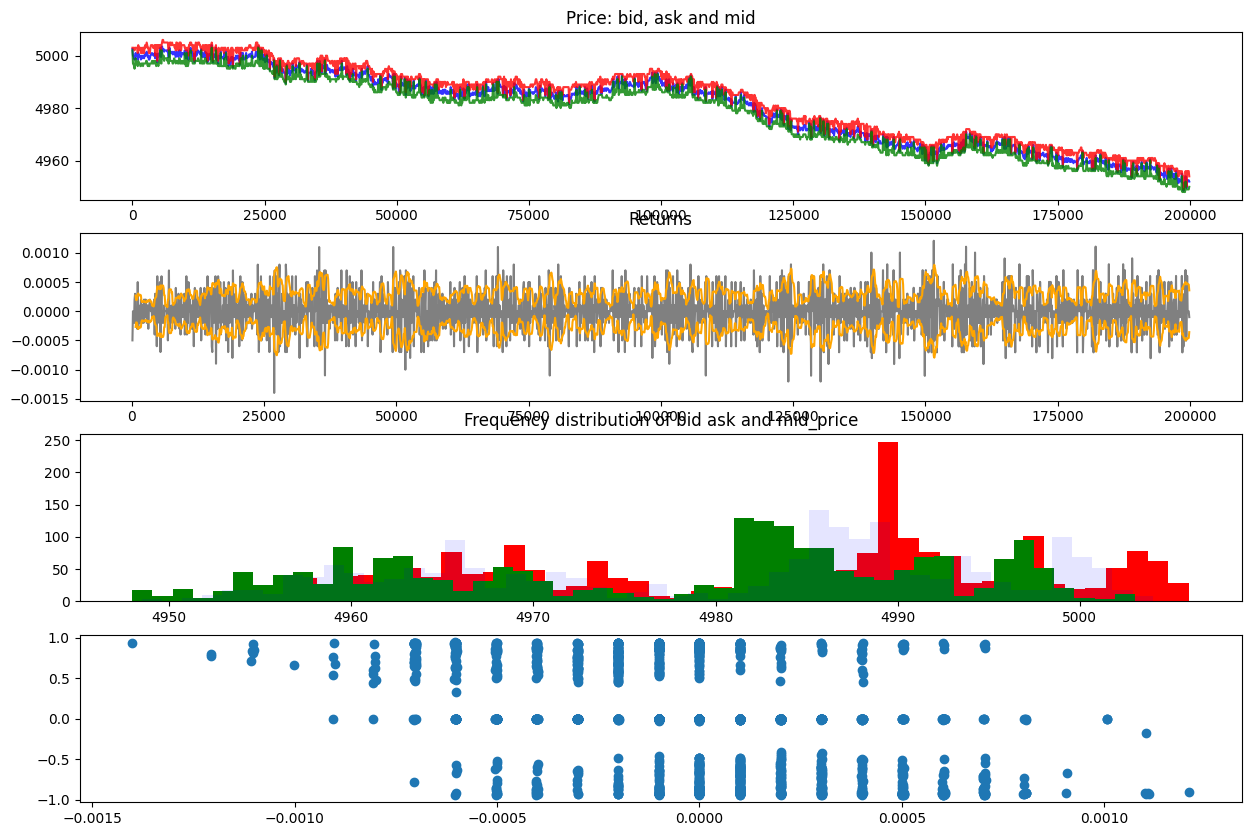

In [590]:
fig, axs = plt.subplots(4, 1, sharex=False, figsize=(15,10))

#midprice
axs[0].plot(dfs["STARFRUIT"].index, dfs["STARFRUIT"]["mid_price"], label="returns", color="blue",alpha=0.80)
axs[0].plot(dfs["STARFRUIT"]["ask_price_1"], label="returns", color="r", alpha=0.80)
axs[0].plot(dfs["STARFRUIT"]["bid_price_1"], label="returns", color="g", alpha=0.80)
axs[0].set_title("Price: bid, ask and mid")

#plot 1: returns
axs[1].plot(dfs["STARFRUIT"]["log_ret"], label="returns", color="grey")
axs[1].plot(dfs["STARFRUIT"]["stdev"], label="returns",color="orange")
axs[1].plot(dfs["STARFRUIT"]["stdev"]*-1, label="returns",color="orange")
axs[1].set_title("Returns")

axs[2].hist(dfs["STARFRUIT"]["ask_price_1"], bins=50, color="red")
axs[2].hist(dfs["STARFRUIT"]["bid_price_1"], bins=50, color="green")
axs[2].hist(dfs["STARFRUIT"]["mid_price"], bins=50, color="blue", alpha=0.10)

axs[2].set_title("Frequency distribution of bid ask and mid_price")

axs[3].scatter(dfs["STARFRUIT"]["returns"],dfs["STARFRUIT"]["order_book_imbalance"])

plt.savefig("charts/EDA_Main_Features.jpg")

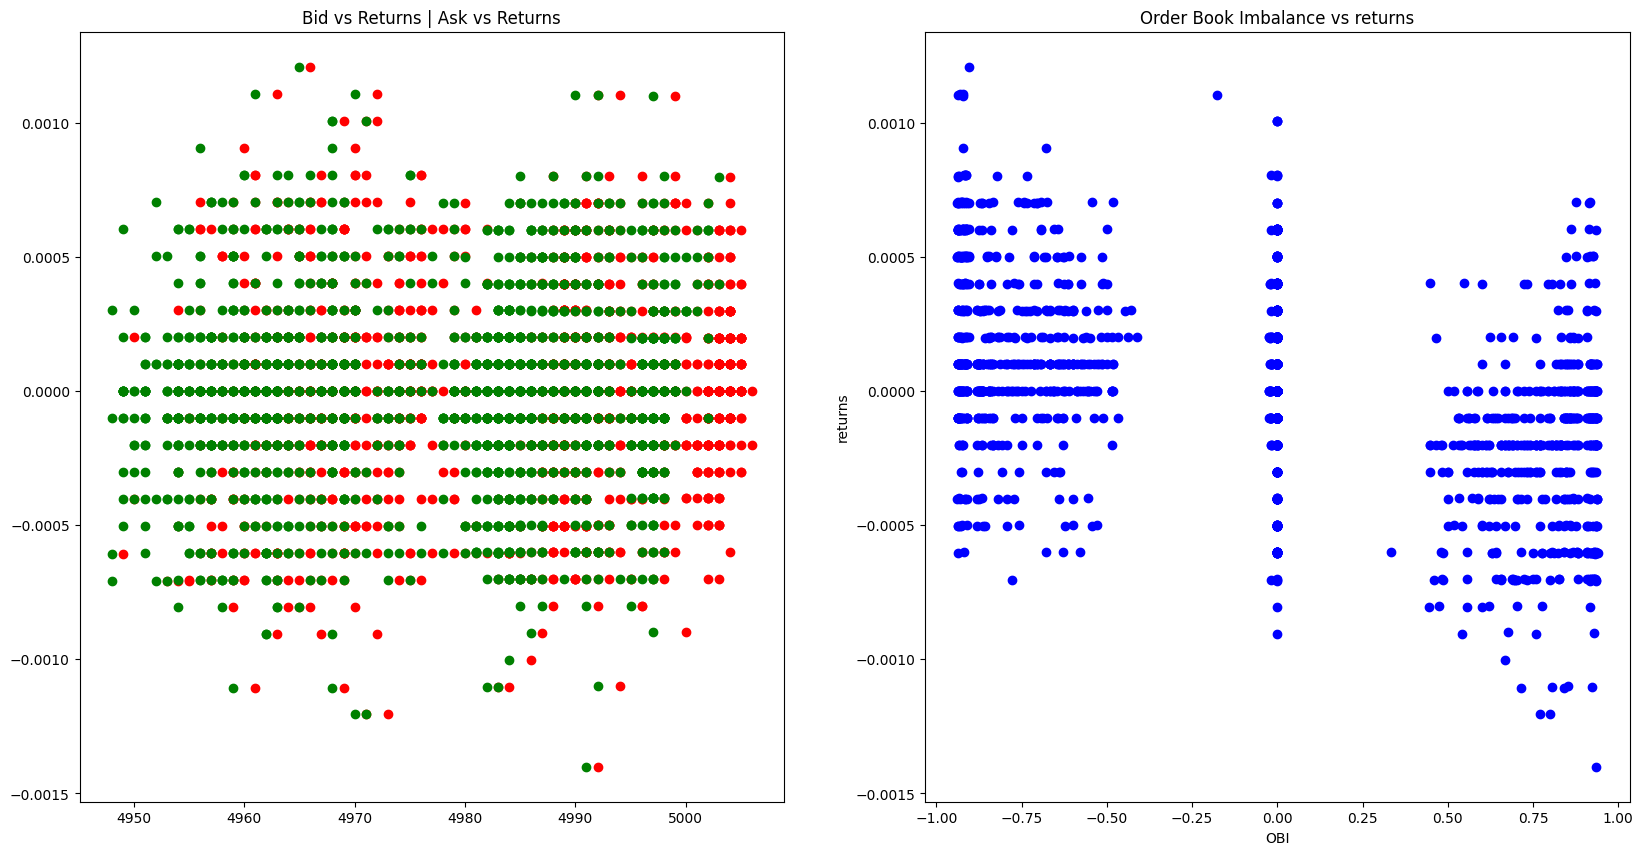

In [588]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].scatter(dfs["STARFRUIT"]["ask_price_1"],dfs["STARFRUIT"]["returns"], color="r")
axs[0].scatter(dfs["STARFRUIT"]["bid_price_1"],dfs["STARFRUIT"]["returns"], color="g")
axs[0].set_title("Bid vs Returns | Ask vs Returns")

axs[1].scatter(dfs["STARFRUIT"]["order_book_imbalance"],dfs["STARFRUIT"]["returns"], color="b")
axs[1].set_title("Order Book Imbalance vs returns")
axs[1].set_xlabel("OBI")
axs[1].set_ylabel("returns")
plt.savefig("charts/Features vs returns")

Visualize LOB

In [571]:
import seaborn as sns

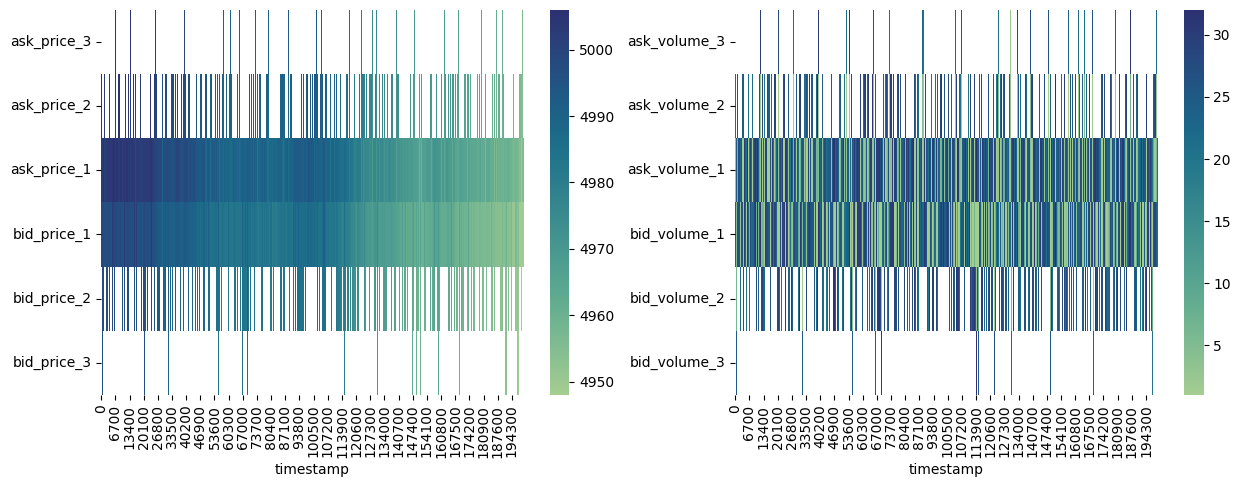

In [572]:
fig,axs = plt.subplots(1,2,figsize=(15,5))
price_cols = ["ask_price_3", "ask_price_2", "ask_price_1", "bid_price_1", "bid_price_2", "bid_price_3"]
volume_cols = ["ask_volume_3", "ask_volume_2", "ask_volume_1", "bid_volume_1", "bid_volume_2", "bid_volume_3"]
LOB_price = dfs["STARFRUIT"][price_cols].T
LOB_volume = dfs["STARFRUIT"][volume_cols].T

sns.heatmap(LOB_price, cmap="crest", ax=axs[0])
sns.heatmap(LOB_volume, cmap="crest", ax=axs[1])
plt.savefig("charts/OrderBook_heatmap.jpg")

In [573]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [574]:
scaler = StandardScaler()
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

product = "STARFRUIT"
cutoff = int(len(dfs["STARFRUIT"])*0.20)
features = ["spread", "order_book_imbalance", "bid_price_1", "ask_price_1", "ask_volume_1","bid_volume_1"]

X = imputer.fit_transform(dfs[product][features]) #for PCA
y = imputer.fit_transform(np.array(dfs[product]["log_ret"]).reshape(-1,1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

X_pca_train = X_scaled[:cutoff]
X_pca_test = X_scaled[cutoff:]

X_train = X[:cutoff]
y_train = y[:cutoff]

print("X length: ",len(X_train), "y len: ",len(y_train))
len(X_train) == len(y_train)

X length:  400 y len:  400


True

In [575]:
model = LinearRegression()
model.fit(X_train, y_train)
model.coef_

array([[ 5.97689487e+03, -8.14592770e-05,  5.97689487e+03,
        -5.97689485e+03,  2.18845231e-06, -6.07477226e-06]])

In [576]:
X_test = (dfs[product][features][cutoff:]).fillna(0).to_numpy()
y_test = (dfs[product]["returns"][cutoff:]).fillna(0).to_numpy()

predictions = model.predict(X_test)

print("All LOB features results\n")
print("MSE: ",mean_squared_error(y_test, predictions))
print("Intercept: ",model.intercept_)
for i in range(len(model.coef_[0])):
    print(model.feature_names_in_[i], ": ", model.coef_[i])

All LOB features results

MSE:  3.037117324585428e-07
Intercept:  [-0.09337007]


AttributeError: 'LinearRegression' object has no attribute 'feature_names_in_'

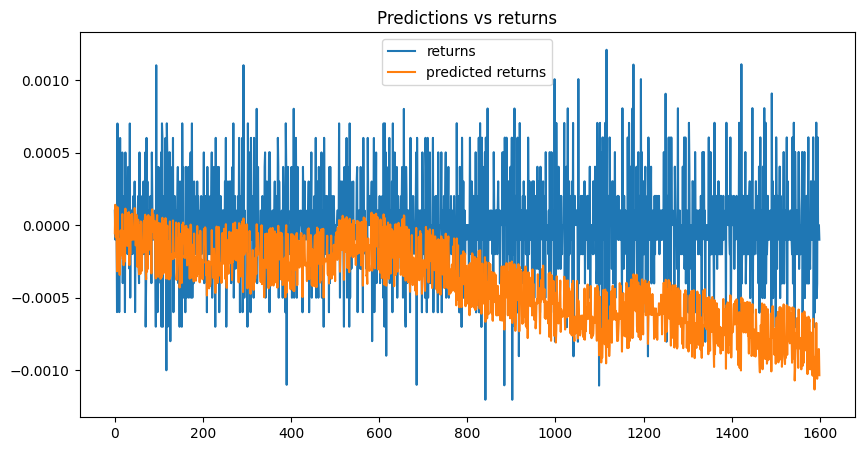

In [577]:
fig, axs = plt.subplots(1,1,figsize=(10,5))

idx = np.arange(len(y_test))
axs.plot(idx,y_test,label="returns")
axs.plot(idx,predictions, label="predicted returns")
plt.title("Predictions vs returns")
plt.legend()
plt.savefig("charts/LinearRegression_test_results")

In [578]:
depth = dfs["STARFRUIT"][price_cols+volume_cols]
ask , bid = depth[[i for i in depth.columns if "ask" in i]], depth[[i for i in depth.columns if "bid" in i]]

depth['depth_ask'] = depth.filter(like='ask_price').notna().sum(axis=1)
depth['depth_bid'] = depth.filter(like='bid_price').notna().sum(axis=1)
depth['depth'] = depth[['depth_ask', 'depth_bid']].min(axis=1)

depth.drop(columns=["depth_bid", "depth_ask"],inplace=True)
ask.iloc[0][f"ask_price_{2}"]

C:\Users\Ramon\AppData\Local\Temp\ipykernel_7896\533797720.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  depth['depth_ask'] = depth.filter(like='ask_price').notna().sum(axis=1)
C:\Users\Ramon\AppData\Local\Temp\ipykernel_7896\533797720.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  depth['depth_bid'] = depth.filter(like='bid_price').notna().sum(axis=1)
C:\Users\Ramon\AppData\Local\Temp\ipykernel_7896\533797720.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

nan

In [592]:
pca = PCA(n_components=3,svd_solver="full")
X_pca_train = pca.fit_transform(X_pca_train)
X_pca_test = pca.transform(X_pca_test)

model.fit(X_pca_train, y_train)

LinearRegression()

In [584]:
predictions = model.predict(X_pca_test)

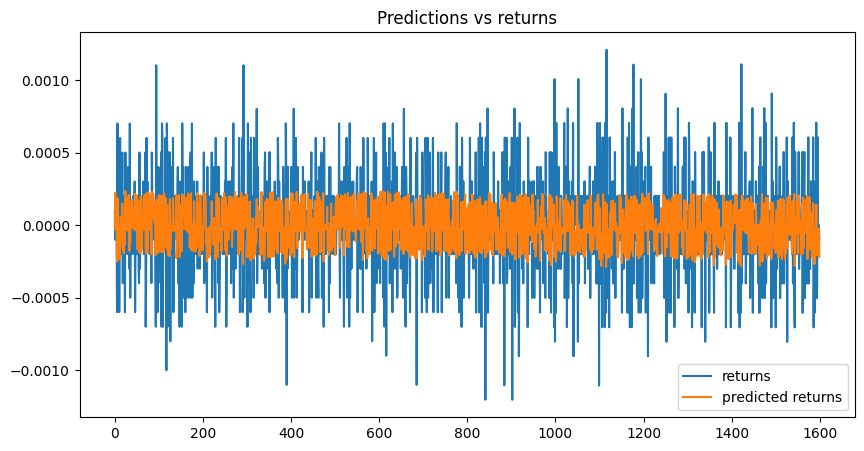

In [591]:
fig, axs = plt.subplots(1,1,figsize=(10,5))

idx = np.arange(len(y_test))
axs.plot(idx,y_test,label="returns")
axs.plot(idx,predictions, label="predicted returns")
plt.title("Predictions vs returns")
plt.legend()
plt.savefig("charts/LinearRegression_test_results")